## Importing libraries and defining necessary functions

In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageEnhance, ImageOps

In [2]:
def enhance_contrast_and_threshold(img, threshold=128):
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(img)
    enhanced_img = enhancer.enhance(3.0)  # Adjust the factor as needed

    # Convert to grayscale and apply binary threshold
    bw = ImageOps.grayscale(enhanced_img)
    bw = bw.point(lambda p: p > threshold and 255)

    return bw

# Importing the Dataset

In [4]:
# Set the path to the root directory
root_path = r"C:\Users\ezgi\Desktop\'23-'24 fall\deep learning\term project\data"
images = []
labels = []

valid_extensions = {".jpg", ".jpeg", ".png"}

for cam_folder in os.listdir(root_path):
    cam_folder_path= os.path.join(root_path, cam_folder)
    for folder_name in os.listdir(cam_folder_path):
        folder_path = os.path.join(cam_folder_path, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if any(file_name.lower().endswith(ext) for ext in valid_extensions):
                    image_path = os.path.join(folder_path, file_name)
                    # Extract label from the file name (the label is the second part split by underscores)
                    label = file_name.split('_')[1]
                    
                    # Load the image using PIL
                    pil_image = Image.open(image_path)

                    # Enhance contrast and apply threshold
                    enhanced_image = enhance_contrast_and_threshold(pil_image)  # CONTRAST

                    # Convert PIL image to NumPy array
                    img = np.array(enhanced_image)

                    if img is None:
                        print(f"Failed to load image: {image_path}")
                    else:
                        img = cv2.resize(img, (64, 64))  # Resize the image to a consistent size
                        images.append(img)
                        labels.append(label)


## Preprocessing

In [5]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape images for compatibility with Conv2D layer
images = images.reshape(images.shape + (1,))

print("Number of images:", len(images))  # Add this line
print("Number of labels:", len(labels))  # Add this line

# Encode labels into numerical format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize pixel values to be between 0 and 1
images = images / 255.0

Number of images: 21042
Number of labels: 21042


## Splitting the Dataset

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Fitting the Model

#### Training the Model with Augmented Data

In [29]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # dropout layer with a dropout rate of 25%
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.5))  # dropout layer with a dropout rate of 50%
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Use softmax for multi-class classification

In [30]:
# Define the optimizer with a custom learning rate (e.g., 0.001)
custom_learning_rate = 0.001
custom_optimizer = Adam(learning_rate=custom_learning_rate)

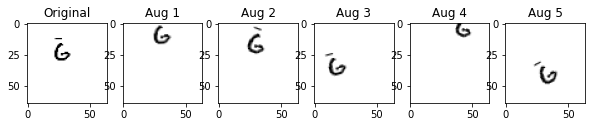

In [37]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an image data generator with data augmentation
datagen = ImageDataGenerator(
    rescale=1/255, 
    rotation_range=30,  # Rotate by up to 10 degrees
    width_shift_range=0.3,  # Shift horizontally by up to 10% of the image width
    height_shift_range=0.2,  # Shift vertically by up to 10% of the image height
    shear_range=0.1,  # Apply shear transformation with a shear intensity of 0.1
    zoom_range=0.1,  # Random zoom in by up to 10%
    horizontal_flip=False,  # Disable horizontal flipping for letters
    fill_mode='nearest'  # Strategy used for filling in newly created pixels
)
# Example usage on a single image
example_letter_image = X_train[56]  # Assuming X_train is your training data
# Reshape the example letter image to include the batch size and channel
example_letter_image = example_letter_image.reshape((1,) + example_letter_image.shape)

# Generate augmented images
augmented_images = []
for batch in datagen.flow(example_letter_image, batch_size=5, save_to_dir=None):
    augmented_images.append(batch)
    if len(augmented_images) >= 5:
        break

# Display the original and augmented images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
plt.subplot(1, 6, 1)
plt.imshow(example_letter_image[0, :, :, 0], cmap='gray')  # Assuming it's a grayscale image
plt.title('Original')

for i, augmented_image in enumerate(augmented_images):
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_image[0, :, :, 0], cmap='gray')  # Assuming it's a grayscale image
    plt.title(f'Aug {i + 1}')

plt.show()

Certain augmentations, such as rotation, might transform one letter into another. However, judicious use of data augmentation can still be helpful for improving the robustness and generalization of the model. Horizontal and vertical shifts, slight rotations, and small zooms are examples of augmentations that might be less likely to transform one letter into another.

In [38]:
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
# Create a generator for training data with data augmentation
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Create a generator for validation data without data augmentation
validation_generator = ImageDataGenerator(rescale=1./255).flow(X_test, y_test, batch_size=32)

In [41]:
# Train the model
history_2 = model.fit(train_generator, epochs=10, batch_size=32, validation_data=validation_generator)

Epoch 1/10
527/527 [==============================] - 37s 70ms/step - loss: 4.1436 - accuracy: 0.0167 - val_loss: 4.1450 - val_accuracy: 0.0126
Epoch 2/10
527/527 [==============================] - 37s 70ms/step - loss: 4.1435 - accuracy: 0.0160 - val_loss: 4.1453 - val_accuracy: 0.0119
Epoch 3/10
527/527 [==============================] - 37s 71ms/step - loss: 4.1435 - accuracy: 0.0169 - val_loss: 4.1454 - val_accuracy: 0.0119
Epoch 4/10
527/527 [==============================] - 36s 68ms/step - loss: 4.1435 - accuracy: 0.0159 - val_loss: 4.1455 - val_accuracy: 0.0119
Epoch 5/10
120/527 [=====>........................] - ETA: 26s - loss: 4.1436 - accuracy: 0.0148

KeyboardInterrupt: 

It looks like model is overfitting (validation accuracy is not changing, even decreasing). So, it is interrupted, and we will continue without data augmentation

#### Training the Model w/o Dropout Layers

In [31]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Record the start time before compilation
start_time = time.time()

model_history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Record the end time after compilation
end_time = time.time()

Epoch 1/30
527/527 [==============================] - 83s 155ms/step - loss: 3.0402 - accuracy: 0.2701 - val_loss: 1.6877 - val_accuracy: 0.5811
Epoch 2/30
527/527 [==============================] - 80s 152ms/step - loss: 1.3019 - accuracy: 0.6832 - val_loss: 1.1735 - val_accuracy: 0.7239
Epoch 3/30
527/527 [==============================] - 80s 152ms/step - loss: 0.9676 - accuracy: 0.7789 - val_loss: 0.9565 - val_accuracy: 0.7819
Epoch 4/30
527/527 [==============================] - 82s 156ms/step - loss: 0.8229 - accuracy: 0.8246 - val_loss: 0.8999 - val_accuracy: 0.7964
Epoch 5/30
527/527 [==============================] - 81s 154ms/step - loss: 0.7275 - accuracy: 0.8525 - val_loss: 0.9158 - val_accuracy: 0.8149
Epoch 6/30
527/527 [==============================] - 82s 156ms/step - loss: 0.6945 - accuracy: 0.8653 - val_loss: 0.7982 - val_accuracy: 0.8451
Epoch 7/30
527/527 [==============================] - 82s 155ms/step - loss: 0.6336 - accuracy: 0.8835 - val_loss: 0.8116 - val_ac

Training in 11 epoch would be a better approach to prevent overfitting

In [33]:
compilation_time = end_time - start_time

# Convert seconds to minutes and seconds
compilation_time_minutes = int(compilation_time // 60)
remaining_seconds = int(compilation_time % 60)

# Print the compilation time in minutes and seconds
print(f"Model compilation time: {compilation_time_minutes} minutes and {remaining_seconds} seconds")


Model compilation time: 40 minutes and 36 seconds


#### Training the Model w/ 3 Convolution Layers

Final Model!

We also tried with different dropout rates, however larger rates leads to underfitting

In [24]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))  # dropout layer with a dropout rate of 10%
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Use softmax for multi-class classification

In [25]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Record the start time before compilation
start_time2 = time.time()

model_history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Record the end time after compilation
end_time2 = time.time()

Epoch 1/30
527/527 [==============================] - 39s 73ms/step - loss: 2.8650 - accuracy: 0.3077 - val_loss: 1.5530 - val_accuracy: 0.6125
Epoch 2/30
527/527 [==============================] - 38s 73ms/step - loss: 1.1880 - accuracy: 0.7024 - val_loss: 1.1089 - val_accuracy: 0.7308
Epoch 3/30
527/527 [==============================] - 38s 72ms/step - loss: 0.8497 - accuracy: 0.8010 - val_loss: 0.9760 - val_accuracy: 0.7707
Epoch 4/30
527/527 [==============================] - 38s 72ms/step - loss: 0.6818 - accuracy: 0.8523 - val_loss: 0.8540 - val_accuracy: 0.8090
Epoch 5/30
527/527 [==============================] - 39s 74ms/step - loss: 0.5957 - accuracy: 0.8822 - val_loss: 0.8236 - val_accuracy: 0.8199
Epoch 6/30
527/527 [==============================] - 39s 73ms/step - loss: 0.5534 - accuracy: 0.8937 - val_loss: 0.9067 - val_accuracy: 0.7912
Epoch 7/30
527/527 [==============================] - 39s 74ms/step - loss: 0.5158 - accuracy: 0.9072 - val_loss: 0.7843 - val_accuracy:

In first 2 epochs, train accuracy is less than the train accuracy. In the early epochs of training, it's not uncommon for the training accuracy to be lower than the test accuracy. Techniques like data augmentation and dropout layers (like in our case) can introduce randomness during training, and they can be the reason for that.

In [27]:
compilation_time2 = end_time2 - start_time2

# Convert seconds to minutes and seconds
compilation_time2_minutes = int(compilation_time2 // 60)
remaining_seconds2 = int(compilation_time2 % 60)

# Print the compilation time in minutes and seconds
print(f"Model compilation time: {compilation_time2_minutes} minutes and {remaining_seconds2} seconds")


Model compilation time: 19 minutes and 20 seconds


#### Saving the Model

model2 performed better, saving this model for the later demo purposes:

In [28]:
# Save the entire model (architecture, optimizer, and learned weights)
model.save("letter_recognition_model.h5")

In [29]:
import joblib
# Save the encoder
joblib.dump(label_encoder, 'letter_label_encoder.joblib')

['letter_label_encoder.joblib']

# Results

In [30]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy * 100:.2f}%')

132/132 [==============================] - 2s 16ms/step - loss: 0.6962 - accuracy: 0.8848
Test loss: 0.6962, Test accuracy: 88.48%


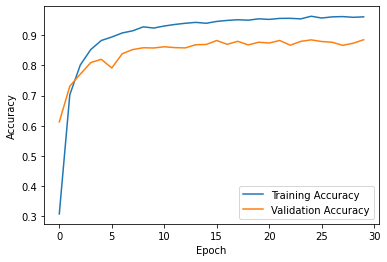

In [31]:
# Plot accuracy and validation accuracy graphs
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plotting 5 random samples from test set

1/1 [==============================] - 0s 22ms/step


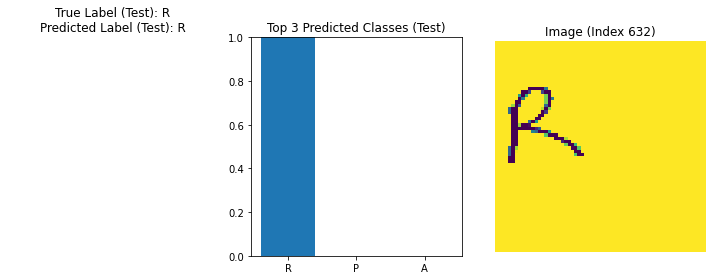

1/1 [==============================] - 0s 18ms/step


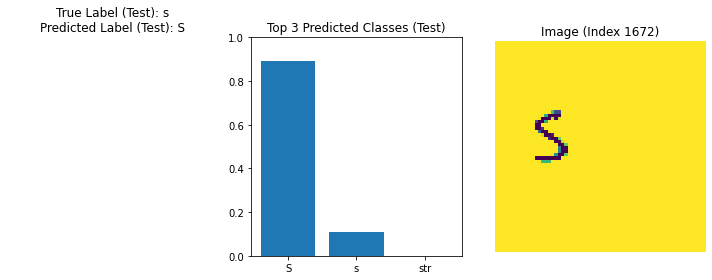

1/1 [==============================] - 0s 26ms/step


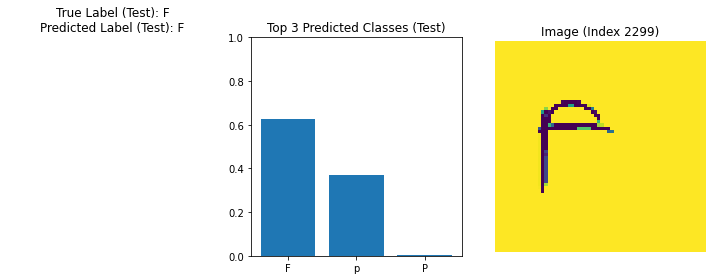

1/1 [==============================] - 0s 19ms/step


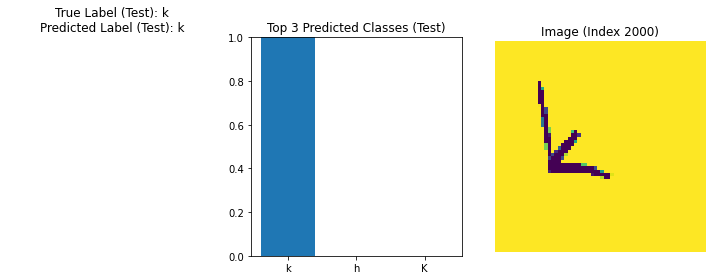

1/1 [==============================] - 0s 21ms/step


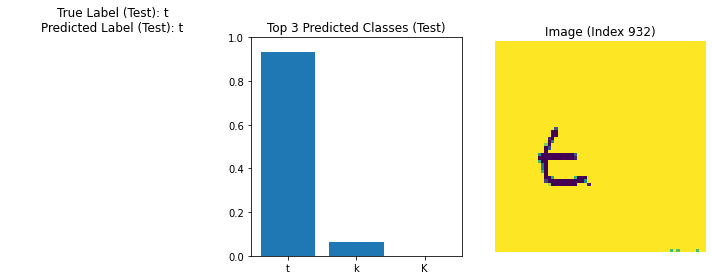

In [35]:
import matplotlib.pyplot as plt
import random

# Plot 5 random examples from the test set
for i in range(5):
    index_test = random.randint(0, len(X_test) - 1)

    # Make prediction on the selected sample from the test set
    prediction_test = model.predict(X_test[index_test:index_test+1])
    predicted_label_test = np.argmax(prediction_test)
    top_three_classes_test = np.argsort(prediction_test[0])[::-1][:3]
    top_three_probabilities_test = prediction_test[0][top_three_classes_test]

    # Display true label, predicted label, and the image itself
    plt.figure(figsize=(10, 4))

    # True label and predicted label
    plt.subplot(1, 3, 1)
    plt.title(f'True Label (Test): {label_encoder.classes_[y_test[index_test]]}\nPredicted Label (Test): {label_encoder.classes_[predicted_label_test]}')
    plt.axis('off')

    # Top three predicted classes and their probabilities (smaller size)
    plt.subplot(1, 3, 2)
    plt.bar(range(3), top_three_probabilities_test)
    plt.title('Top 3 Predicted Classes (Test)')
    plt.xticks(range(3), label_encoder.classes_[top_three_classes_test], rotation=0)
    plt.ylim(0, 1)  # Set the y-axis limit to 0-1 for probability values

    # Image
    plt.subplot(1, 3, 3)
    plt.title(f'Image (Index {index_test})')
    plt.imshow(X_test[index_test])
    plt.axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()


### Plotting 5 wrong predicted random samples from train set

Since the accuracy of the train set is high, we are plotting wrong predicted samples. Visualizing misclassifications can provide insights into potential patterns or challenges that the model is facing.

1/1 [==============================] - 0s 16ms/step


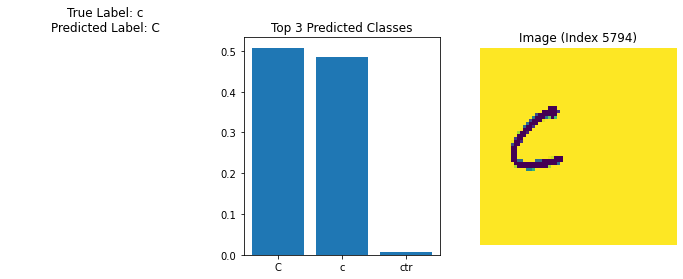

1/1 [==============================] - 0s 28ms/step


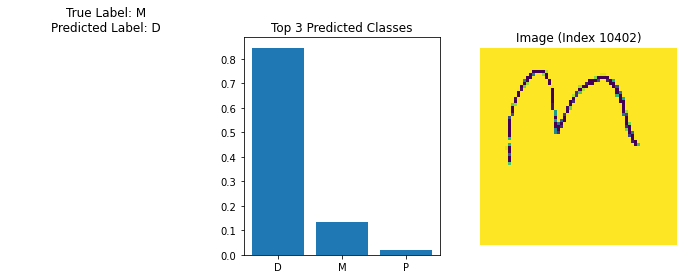

1/1 [==============================] - 0s 14ms/step


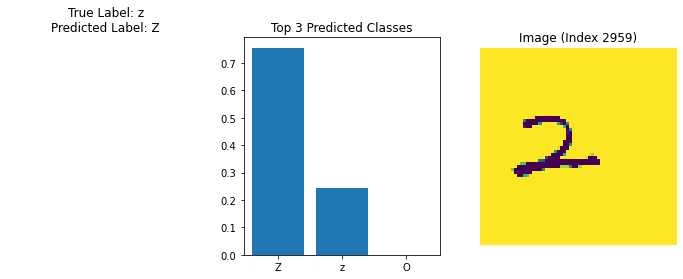

1/1 [==============================] - 0s 17ms/step


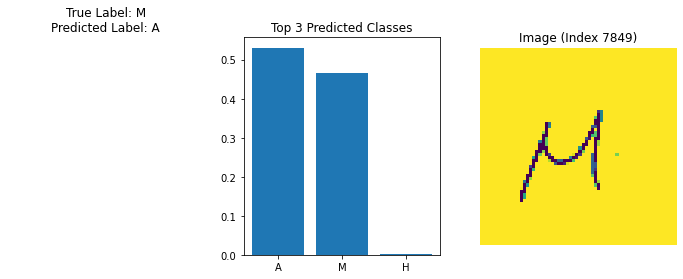

1/1 [==============================] - 0s 38ms/step


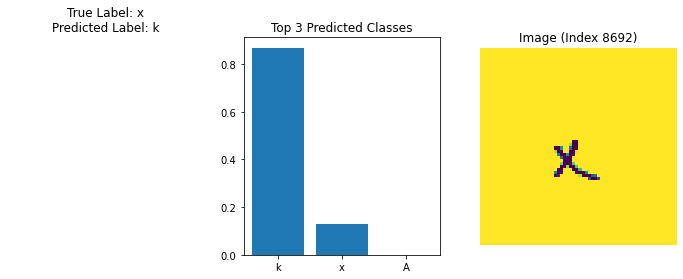

In [36]:
import matplotlib.pyplot as plt
import random

# Make predictions on the entire training set
predictions_train = model.predict(X_train)
predicted_labels_train = np.argmax(predictions_train, axis=1)

# Find indices of incorrectly predicted samples
incorrect_indices_train = np.where(predicted_labels_train != y_train)[0]

# Plot 5 random examples from the training set that were predicted wrong
for i in range(5):
    index_train = random.choice(incorrect_indices_train)

    # Make prediction on the selected sample from the training set
    prediction_train = model.predict(X_train[index_train:index_train+1])
    predicted_label_train = np.argmax(prediction_train)
    top_three_classes = np.argsort(prediction_train[0])[::-1][:3]
    top_three_probabilities = prediction_train[0][top_three_classes]

    # Display true label, predicted label, and the image itself
    plt.figure(figsize=(12, 4))

    # True label and predicted label
    plt.subplot(1, 3, 1)
    plt.title(f'True Label: {label_encoder.classes_[y_train[index_train]]}\nPredicted Label: {label_encoder.classes_[predicted_label_train]}')
    plt.axis('off')

    # Top three predicted classes and their probabilities
    plt.subplot(1, 3, 2)
    plt.bar(range(3), top_three_probabilities)
    plt.title('Top 3 Predicted Classes')
    plt.xticks(range(3), label_encoder.classes_[top_three_classes], rotation=0)

    # Image
    plt.subplot(1, 3, 3)
    plt.title(f'Image (Index {index_train})')
    plt.imshow(X_train[index_train])
    plt.axis('off')

    plt.show()


132/132 [==============================] - 2s 15ms/step


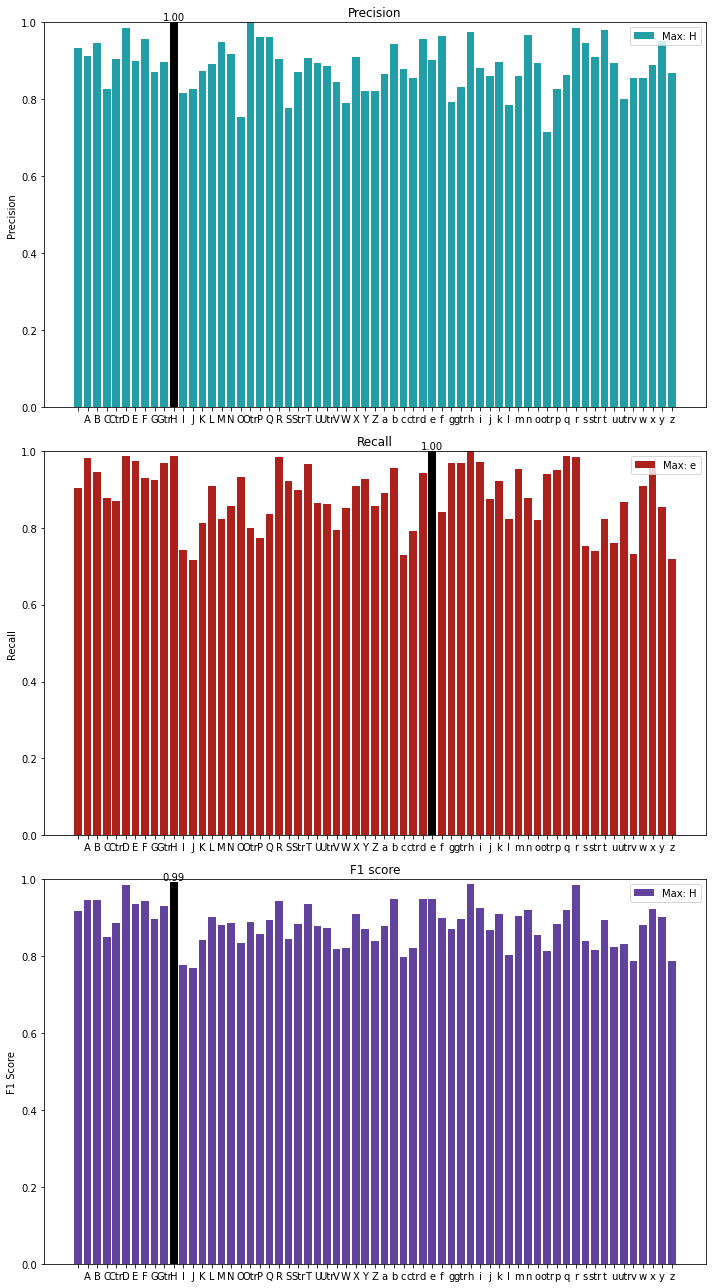

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Use the trained model to predict classes on the test set
predictions = model.predict(X_test)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Decode the encoded labels back to the original labels
decoded_true_labels = label_encoder.inverse_transform(y_test)
decoded_predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Obtain confusion matrix
conf_matrix = confusion_matrix(decoded_true_labels, decoded_predicted_labels, labels=label_encoder.classes_)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(decoded_true_labels, decoded_predicted_labels, average=None)
recall = recall_score(decoded_true_labels, decoded_predicted_labels, average=None)
f1 = f1_score(decoded_true_labels, decoded_predicted_labels, average=None)

# Colors for the bars
precision_color = '#229EA6'
recall_color = '#AD211D'
f1_color = '#61439D'
highlight_color = 'black'

# Find the class with the highest precision, recall, and F1 score
max_precision_class = label_encoder.classes_[np.argmax(precision)]
max_recall_class = label_encoder.classes_[np.argmax(recall)]
max_f1_class = label_encoder.classes_[np.argmax(f1)]

# Plot precision, recall, and F1 score for each class in subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Plot precision
max_precision_index = np.argmax(precision)
axes[0].bar(label_encoder.classes_, precision, color=precision_color, label=f'Max: {max_precision_class}')
axes[0].bar(label_encoder.classes_[max_precision_index], precision[max_precision_index], color=highlight_color)
axes[0].text(max_precision_index, precision[max_precision_index], f'{precision[max_precision_index]:.2f}', ha='center', va='bottom', color=highlight_color)
axes[0].set_title('Precision')
axes[0].set_ylabel('Precision')
axes[0].set_ylim(0., 1.0)  # Adjusted the y-axis limit
axes[0].legend()

# Plot recall
max_recall_index = np.argmax(recall)
axes[1].bar(label_encoder.classes_, recall, color=recall_color, label=f'Max: {max_recall_class}')
axes[1].bar(label_encoder.classes_[max_recall_index], recall[max_recall_index], color=highlight_color)
axes[1].text(max_recall_index, recall[max_recall_index], f'{recall[max_recall_index]:.2f}', ha='center', va='bottom', color=highlight_color)
axes[1].set_title('Recall')
axes[1].set_ylabel('Recall')
axes[1].set_ylim(0., 1.0)  # Adjusted the y-axis limit
axes[1].legend()

# Plot F1 score
max_f1_index = np.argmax(f1)
axes[2].bar(label_encoder.classes_, f1, color=f1_color, label=f'Max: {max_f1_class}')
axes[2].bar(label_encoder.classes_[max_f1_index], f1[max_f1_index], color=highlight_color)
axes[2].text(max_f1_index, f1[max_f1_index], f'{f1[max_f1_index]:.2f}', ha='center', va='bottom', color=highlight_color)
axes[2].set_title('F1 score')
axes[2].set_ylabel('F1 Score')
axes[2].set_ylim(0., 1.0)  # Adjusted the y-axis limit
axes[2].legend()

plt.tight_layout()
plt.show()
